# VAE Tutorial (Part 2)

This is the second half of the tutorial that started [here](https://github.com/eemlcommunity/PracticalSessions2021/blob/main/generative/1_VAEs.ipynb).

We explore disentangling representations with beta-VAEs.

To do so, we

* Use the [dsprites](https://www.tensorflow.org/datasets/catalog/dsprites) dataset.
* Modify the loss slightly so we can set a targeted KL size schedule.

## Setup and Helpers

In [5]:
#@title RUN this cell to install and import required libraries
!pip install -q git+https://github.com/deepmind/dm-haiku
!pip install -q dm-haiku optax

from typing import Any, Iterator, Iterable, Generator, Mapping, Tuple, NamedTuple, Sequence

from collections import defaultdict, namedtuple
# from absl import app
# from absl import flags
# from absl import logging
import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import optax

import tensorflow.image
import tensorflow_datasets as tfds

import math
from pprint import pprint

import sklearn.manifold
import scipy.stats

import pandas as pd
import seaborn as sns

# import functools

# %matplotlib inline


In [6]:
#@title Python Type Declarations
OptState = Any
PRNGKey = jnp.ndarray
Batch = Mapping[str, np.ndarray]


In [7]:
#@title Dataset Loading and Visualization

DATA_SHUFFLE_LENGTH = 50  # In terms of batch_size.

def gallery(
    images, labels: Sequence[int] = None,
    max_images: int = 10, max_fig_size=(30, 30)):
  
  num_frames, h, w, num_channels = images.shape
  num_frames = min(num_frames, max_images)
  ff, axes = plt.subplots(1, num_frames,
                          figsize=max_fig_size,
                          subplot_kw={'xticks': [], 'yticks': []})
  if num_frames == 1:
    axes = [axes]

  # All outputs in the notebook are supposed to be between 0 and 1
  images = np.clip(images, 0.0, 1.0)
  
  for i in range(0, num_frames):
    if num_channels == 3:
      axes[i].imshow(np.squeeze(images[i]))
    else:
      axes[i].imshow(np.squeeze(images[i]), cmap='gray')
    if labels is not None:
      axes[i].set_title(CLASS_LABELS[labels[i]], fontsize=28)
    plt.setp(axes[i].get_xticklabels(), visible=False)
    plt.setp(axes[i].get_yticklabels(), visible=False)
  ff.subplots_adjust(wspace=0.1)
  plt.show()


# Mnist and FashionMnist sizes:
DSPRITES_EXAMPLES = 737280

def load_dsprites_ds(batch_size: int) -> Iterator[Batch]:
  ds = tfds.load("dsprites", split='train', shuffle_files=True)
  ds = ds.cache()  # Cache the normalized version
  ds = ds.shuffle(buffer_size=DSPRITES_EXAMPLES)  # fully random
  ds = ds.repeat()  # Forever.
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=5)
  
  def ds_with_float_img():
    for x in tfds.as_numpy(ds):
      x['image'] = x['image'].astype('float32')
      yield x

  return ds_with_float_img()


In [8]:
#@title subplots helper
def make_subplots(num_plots, max_cols, figwidth=12):
  if num_plots > max_cols:
    y = max_cols
    x = int(math.ceil(num_plots/y))
  else:
    x = 1
    y = num_plots
  figsize = (figwidth, figwidth/y*x)
  fig, axes = plt.subplots(x, y, figsize=figsize)

  # In all cases, make ax a flat list of axes.
  if num_plots == 1:
    return [axes]
  elif x == 1 or y == 1:
    return axes
  else:
    all_axes = []
    for axs in axes:
      all_axes.extend(axs)
    return all_axes[:num_plots]


## Explore dSprites


In [9]:
dsprites_ds = load_dsprites_ds(batch_size=32)

In [10]:
batch = next(dsprites_ds)

print('keys in dataset:', str(batch.keys()).replace(', ', ',\n  '))
print('image stats:', [f(batch['image']) for f in (np.min, np.mean, np.max)])
print('image shape:', batch['image'].shape)
print('image dtype:', batch['image'].dtype)

DSPRITES_IMAGE_SHAPE = batch['image'].shape[1:]

keys in dataset: dict_keys(['image',
  'label_orientation',
  'label_scale',
  'label_shape',
  'label_x_position',
  'label_y_position',
  'value_orientation',
  'value_scale',
  'value_shape',
  'value_x_position',
  'value_y_position'])
image stats: [0.0, 0.0385437, 1.0]
image shape: (32, 64, 64, 1)
image dtype: float32


In [11]:
batch = next(dsprites_ds)

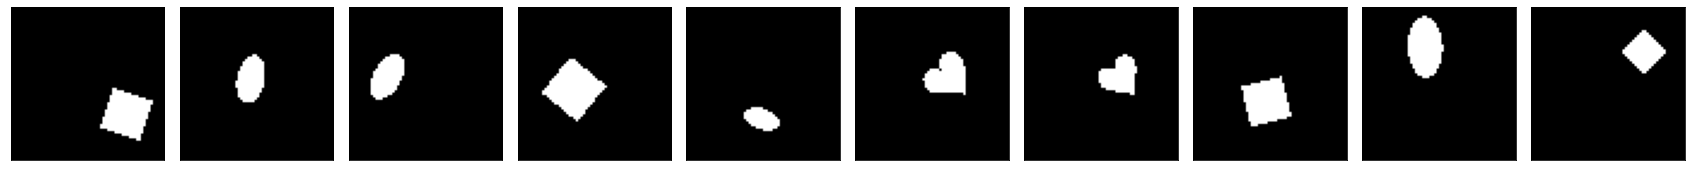

In [12]:
gallery(batch['image'])

In [13]:
del dsprites_ds

It looks like this dataset has larger images, and each image is strictly black and white.

## The VAE Model

This is the same as in part 1.

In [14]:
RecOutput = namedtuple(
    'RecOutput',
    ['mean_image', 'sampled_image', 'logits', 'z', 'mean', 'stddev']
)

VaeApply = namedtuple(
    'VaeApply',
    ['encode', 'decode', 'reconstruct', 'sample']
)


class MlpVAE():

  def __init__(
      self,
      num_linear_units: Sequence[int],
      latent_size: int,
      output_shape: Sequence[int]):  # Not including batch dim.
    """An MLP VAE architecture.

    The encoder is a sequence of linear (fully connected) layers, with the 
    specified number of units. This then linearly map into a mean and stddev
    vector to parametrize Gaussians over the latent space. The decoder is the
    "inversion" of the sequence of linear encoder layers.

    Both the encoder and the decoder uses ReLU throughout.
    """
    self._latent_size = latent_size
    self._num_linear_units = num_linear_units
    self._output_shape = output_shape
    self._output_units = np.prod(np.array(output_shape))
    
  def _get_gaussian_params(self, x):
    """Maps to the mean and stddev of a guassian over the latent space."""
    # Linear layers act only on the last axis, so flatten the data first.
    x = hk.Flatten()(x)

    for idx, num_units in enumerate(self._num_linear_units):
      x = hk.Linear(num_units, name=f"encode_fc_{idx}")(x)
      x = jax.nn.relu(x)
    
    mean = hk.Linear(self._latent_size, name=f"encode_fc_mean")(x)
    log_stddev = hk.Linear(self._latent_size, name=f"encode_fc_stddev")(x)
    stddev = jnp.exp(log_stddev)   # Could also use softplus: log(1+e^x).
    return mean, stddev

  def encode(self, x):
    """Returns (z_sample, (mean, var))."""
    # Sample from N(0, 1), and scale and shift the distribution to make
    # it distributed according to N(mean, stddev^2).
    mean, stddev = self._get_gaussian_params(x)
    normal_sample = jax.random.normal(hk.next_rng_key(), mean.shape)
    z = mean + stddev * normal_sample
    return z, (mean, stddev)

  def _get_logits(self, z):
    """Returns the "logits" for a pixel-wise bernoulli distr over the image."""
    x = z
    for idx, num_units in enumerate(reversed(self._num_linear_units)):
      x = hk.Linear(num_units, name=f"decode_fc_{idx}")(x)
      x = jax.nn.relu(x)

    x = hk.Linear(self._output_units, name=f"decode_fc_last")(x)
    return hk.Reshape(self._output_shape)(x)

  def decode(self, z):
    """Returns a pixel-wise bernoulli distribution over the image space."""
    logits = self._get_logits(z)
    # Apply sigmoid to bring to [0, 1]-range.
    mean_image = jax.nn.sigmoid(logits)
    sampled_image = jax.random.bernoulli(hk.next_rng_key(), mean_image)
    return mean_image, (logits, sampled_image)

  def reconstruct(self, x):
    """A sampled reconstruction; returns a `RecOutput`."""
    z, (mean, stddev) = self.encode(x)
    mean_image, (logits, sampled_image) = self.decode(z)
    return RecOutput(mean_image, sampled_image, logits, z, mean, stddev)

  def sample(self, num_samples):
    """Sample from the learnt distribution -- decode samples from the prior."""
    sampled_z = jax.random.normal(
        hk.next_rng_key(), (num_samples, self._latent_size))
    return self.decode(sampled_z)


In [15]:
def dsprites_vae_fn():
  vae = MlpVAE(
      num_linear_units=(2000, 1600, 512),
      latent_size=10,
      output_shape=DSPRITES_IMAGE_SHAPE,
  )

  def init(x):
    return vae.reconstruct(x)

  return init, VaeApply(vae.encode, vae.decode, vae.reconstruct, vae.sample)


## Training

### Disentangling Loss Calculation

We further modify the loss to be:

<center><img src=https://screenshot.googleplex.com/A8ojNo9sLzfEvcN.png /></center>

which allows us to target some KL with $C$ -- controlling the encoding capacity of the VAE's latent bottleneck. $C$ will be gradually increased from zero to a value large enoough to produce good quality reconstructions.

The kl and binary_cross_entropy calculations are the same as in part 1.

In [19]:
def kl_gaussian(mean: jnp.ndarray, variance: jnp.ndarray) -> jnp.ndarray:
  """Calculate KL between a given and standard gaussian distributions."""
  kl_divergence_vector = 0.5 * (-jnp.log(variance) - 1.0 + variance + mean**2)
  return jnp.sum(kl_divergence_vector, axis=-1)  # Sum over latent dimensions.


def binary_cross_entropy(x: jnp.ndarray, logits: jnp.ndarray) -> jnp.ndarray:
  """Calculate binary (logistic) cross-entropy from distribution logits.

  Args:
    x: input variable tensor, must be of same shape as logits
    logits: log odds of a Bernoulli distribution, i.e. log(p/(1-p))
  Returns:
    A batch of scalars representing binary CE for the given Bernoulli
    distribution.
  """
  if x.shape != logits.shape:
    raise ValueError("inputs x and logits must be of the same shape")

  x = jnp.reshape(x, (x.shape[0], -1))
  logits = jnp.reshape(logits, (logits.shape[0], -1))

  # Use logaddexp(x1, x2) for numerically good "log(exp(x1) + exp(x2))"
  return -jnp.sum(x * logits - jnp.logaddexp(0.0, logits), axis=-1)


In [20]:
def disentangling_elbo(
    gamma: jnp.ndarray, kl_target: jnp.ndarray,
    x: jnp.ndarray, logits: jnp.ndarray, 
    mean: jnp.ndarray, stddev: jnp.ndarray
) -> jnp.ndarray:
    """Calculate the modified ELBO training objective. Allows control over KL.
    
    Args:
      gamma: scalar on the KL kl_target matching loss.
      kl_target: the target KL.
      x: data whose likelihood we are interested in.
      logits: the logodds (logits) of the decoded distribution from the model.
      mean: mean of the q(z|x).
      stddev: stddev of the q(z|x).
 
    Returns:
      The training objective, log_likelihood and kl averaged over the batch.
    """
    log_likelihood = -binary_cross_entropy(x, logits)
    kl = kl_gaussian(mean, stddev**2)
    loss = log_likelihood - gamma * jnp.abs(kl - kl_target)

    return jnp.mean(loss), jnp.mean(log_likelihood), jnp.mean(kl)

### Training Code

In [21]:
def disentangled_training(
    vae_fn, final_kl_target=25, gamma=1000, num_epochs=15):
  batch_size = 128
  train_ds = load_dsprites_ds(batch_size)

  rng_seq = hk.PRNGSequence(42)
  optimizer = optax.adam(5e-4)
  vae = hk.multi_transform(vae_fn)
  params = vae.init(next(rng_seq), jnp.zeros((1, *DSPRITES_IMAGE_SHAPE)))
  opt_state = optimizer.init(params)
  num_total_examples = DSPRITES_EXAMPLES * num_epochs

  @jax.jit
  def loss_fn(
      params: hk.Params, rng_key: PRNGKey, images: jnp.ndarray,
      num_examples_done: jnp.ndarray,
  ) -> jnp.ndarray:
      """Return the loss and its components."""
      kl_target = final_kl_target * num_examples_done / num_total_examples 
      output = vae.apply.reconstruct(params, rng_key, images)
      return disentangling_elbo(
          gamma, kl_target, images, output.logits, output.mean, output.stddev
          ) + (kl_target,)

  @jax.jit
  def update(
      params: hk.Params, rng_key: PRNGKey, opt_state: OptState, images: jnp.ndarray,
      num_examples_done: jnp.ndarray,
  ) -> Tuple[hk.Params, OptState]:
    """Single update step."""
    def _just_loss(params, rng_key, images, num_examples_done):
      # NOTE the negative on the elbo!
      return -loss_fn(params, rng_key, images, num_examples_done)[0]

    grads = jax.grad(_just_loss)(params, rng_key, images, num_examples_done)
    elbo, ll, kl, kl_target = loss_fn(params, rng_key, images, num_examples_done)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, elbo, ll, kl, kl_target

  training_stats = defaultdict(list)
  num_examples_done = jnp.array(0, dtype=jnp.float32)  # Not happy with ints.
  for epoch in range(num_epochs+1):

    if epoch > 0:
      # Collect stats on an untrained model, so do not train.
      elbs, lls, kls, kl_targets = [], [], [], []
      for step_in_epoch in range(DSPRITES_EXAMPLES // batch_size):
        batch = next(train_ds)
        params, opt_state, elb, ll, kl, kl_target = update(
            params, next(rng_seq), opt_state, batch['image'], num_examples_done)
        elbs.append(elb)
        lls.append(ll)
        kls.append(kl)
        kl_targets.append(kl_target)
        # num_examples_done = num_examples_done + jnp.array(batch_size, dtype=jnp.float32)
        num_examples_done = num_examples_done + batch_size

        if (step_in_epoch % 1000) == 0:
          print(f"step {step_in_epoch}/{DSPRITES_EXAMPLES // batch_size} in epoch {epoch}")
      
      elb = np.array(elbs).mean()
      ll = np.array(lls).mean()
      kl = np.array(kls).mean()
      kl_target = np.array(kl_targets).mean()


    else:
      # There is no validation set so for the first, before training datapoint
      # we use some training batches to estimate the quantities we are
      # interested in.
      images = []
      for _ in range(50):
        images.append(next(train_ds)['image'])
      images = jnp.concatenate(images, axis=0)
      elb, ll, kl, kl_target = loss_fn(params, next(rng_seq), images, 0)
      del images  # To make space.

    print("\n")
    print(f"EPOCH: {epoch}; Train elbo (-loss): {elb};")
    
    training_stats['train_elbo'].append(elb)
    training_stats['kl_target'].append(kl_target)
    training_stats['train_kl'].append(kl)
    training_stats['train_ll'].append(ll)
    training_stats['epoch'].append(epoch)

    another_batch = next(train_ds)
    output = vae.apply.reconstruct(
        params, next(rng_seq), another_batch['image'])
    # We don't display labels, we show the image to be reconstructed.
    print('Original then reconstruction.')
    gallery(another_batch['image'])
    gallery(output.mean_image)
  
  return vae, params, training_stats


### Train



EPOCH: 0; Train elbo (-loss): -2888.635009765625;
Original then reconstruction.


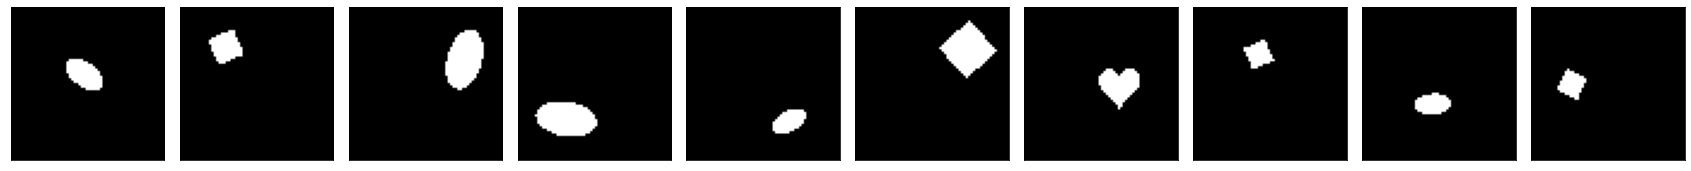

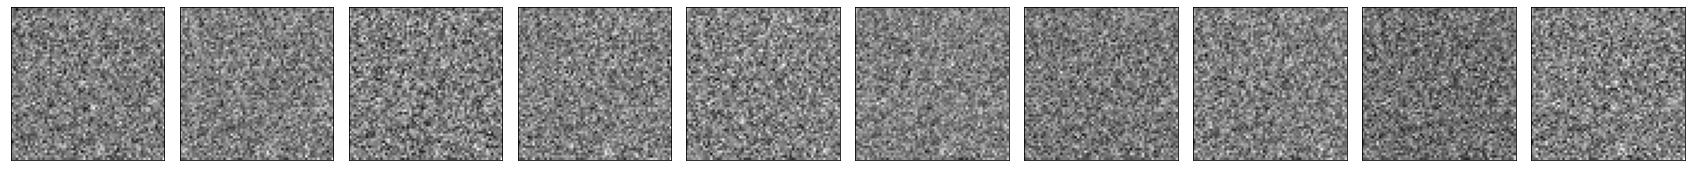

step 0/5760 in epoch 1
step 1000/5760 in epoch 1
step 2000/5760 in epoch 1
step 3000/5760 in epoch 1
step 4000/5760 in epoch 1
step 5000/5760 in epoch 1


EPOCH: 1; Train elbo (-loss): -463.1119384765625;
Original then reconstruction.


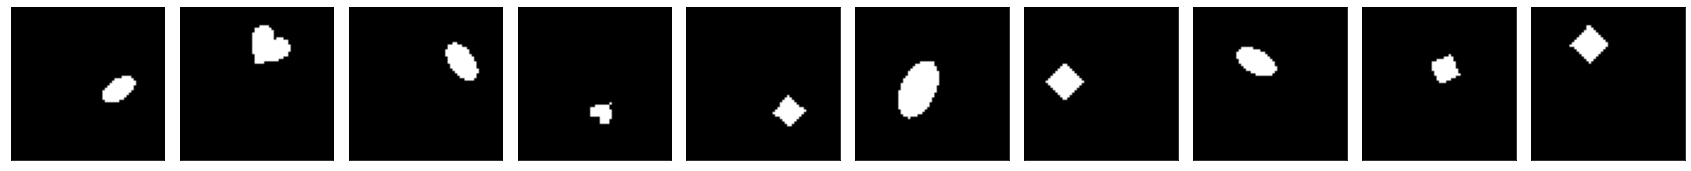

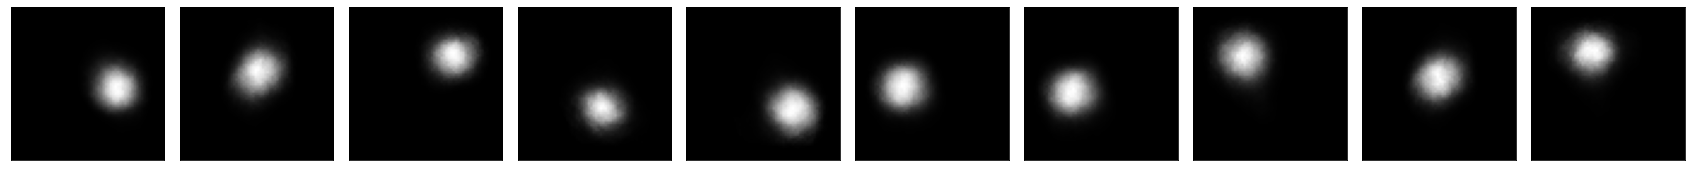

step 0/5760 in epoch 2
step 1000/5760 in epoch 2
step 2000/5760 in epoch 2
step 3000/5760 in epoch 2
step 4000/5760 in epoch 2
step 5000/5760 in epoch 2


EPOCH: 2; Train elbo (-loss): -296.4765625;
Original then reconstruction.


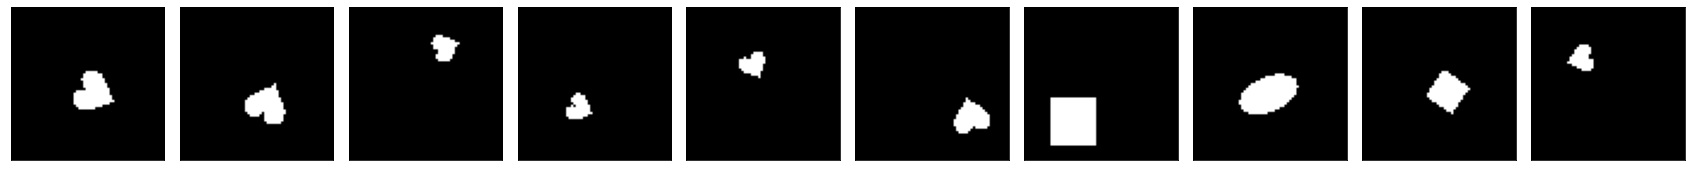

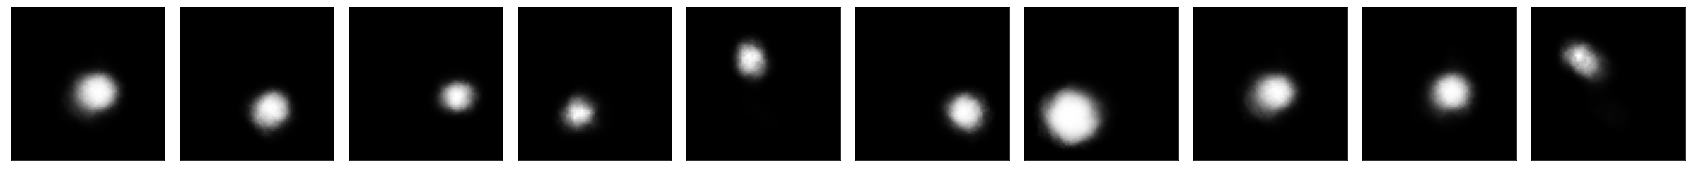

step 0/5760 in epoch 3
step 1000/5760 in epoch 3
step 2000/5760 in epoch 3
step 3000/5760 in epoch 3
step 4000/5760 in epoch 3
step 5000/5760 in epoch 3


EPOCH: 3; Train elbo (-loss): -229.31716918945312;
Original then reconstruction.


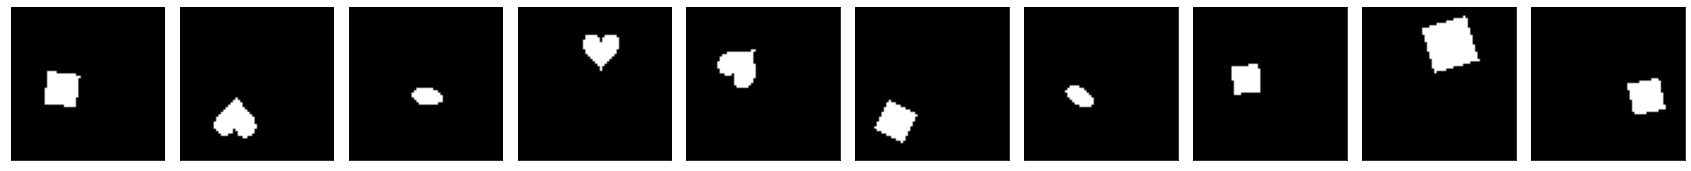

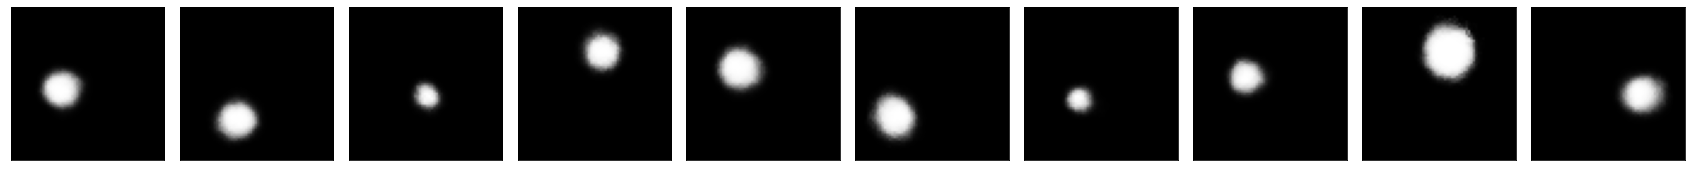

step 0/5760 in epoch 4
step 1000/5760 in epoch 4
step 2000/5760 in epoch 4
step 3000/5760 in epoch 4
step 4000/5760 in epoch 4
step 5000/5760 in epoch 4


EPOCH: 4; Train elbo (-loss): -180.55136108398438;
Original then reconstruction.


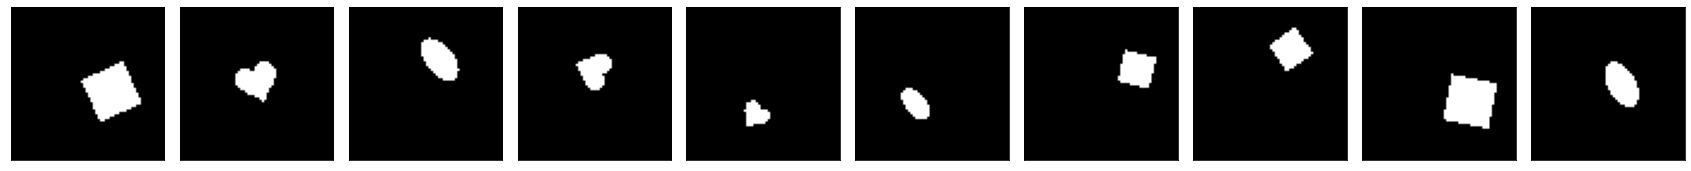

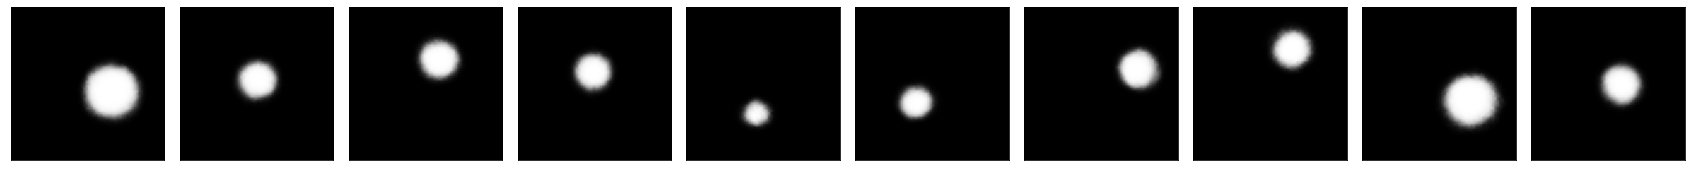

step 0/5760 in epoch 5
step 1000/5760 in epoch 5
step 2000/5760 in epoch 5
step 3000/5760 in epoch 5
step 4000/5760 in epoch 5
step 5000/5760 in epoch 5


EPOCH: 5; Train elbo (-loss): -158.44210815429688;
Original then reconstruction.


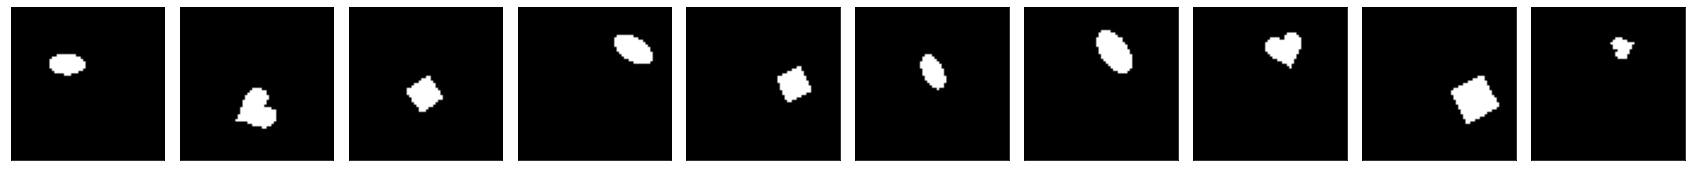

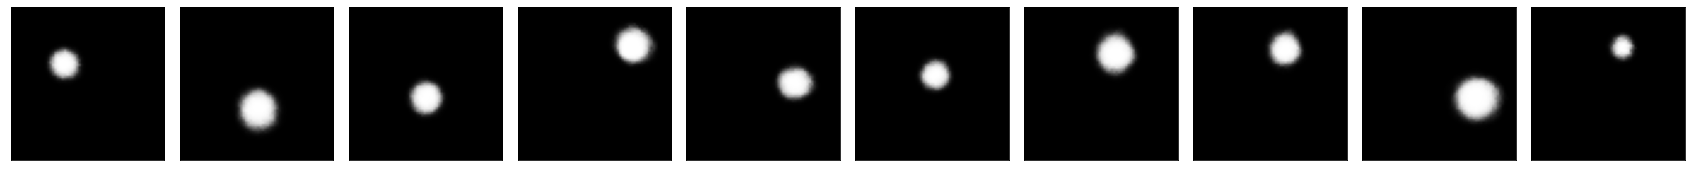

step 0/5760 in epoch 6
step 1000/5760 in epoch 6
step 2000/5760 in epoch 6
step 3000/5760 in epoch 6
step 4000/5760 in epoch 6
step 5000/5760 in epoch 6


EPOCH: 6; Train elbo (-loss): -154.95938110351562;
Original then reconstruction.


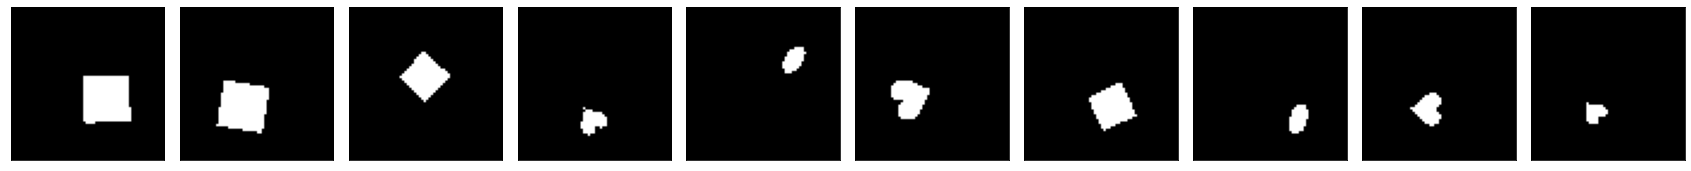

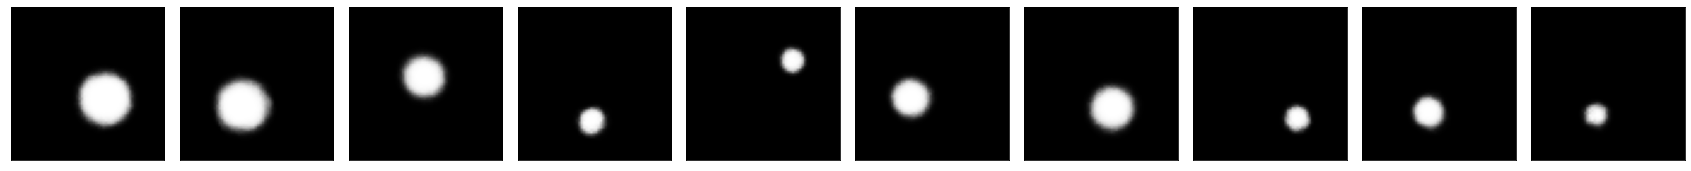

step 0/5760 in epoch 7
step 1000/5760 in epoch 7
step 2000/5760 in epoch 7
step 3000/5760 in epoch 7
step 4000/5760 in epoch 7
step 5000/5760 in epoch 7


EPOCH: 7; Train elbo (-loss): -150.34072875976562;
Original then reconstruction.


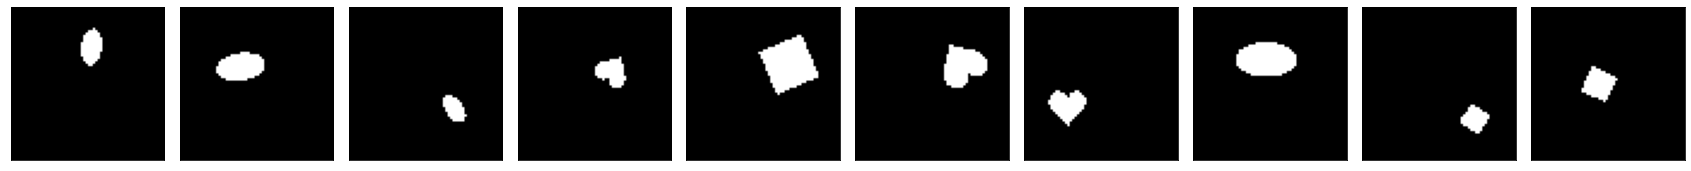

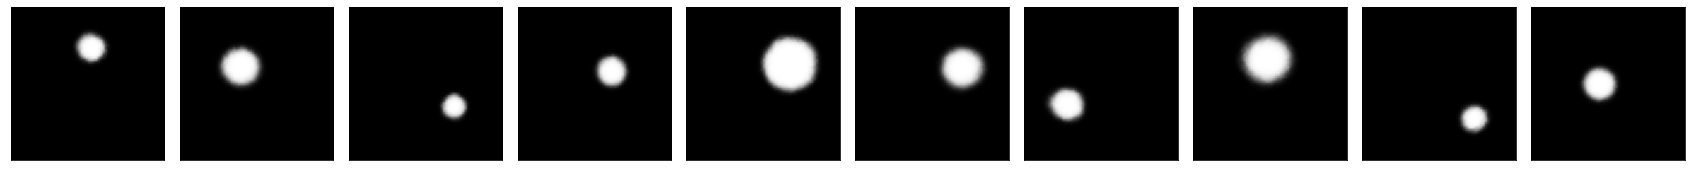

step 0/5760 in epoch 8
step 1000/5760 in epoch 8
step 2000/5760 in epoch 8
step 3000/5760 in epoch 8
step 4000/5760 in epoch 8
step 5000/5760 in epoch 8


EPOCH: 8; Train elbo (-loss): -150.43345642089844;
Original then reconstruction.


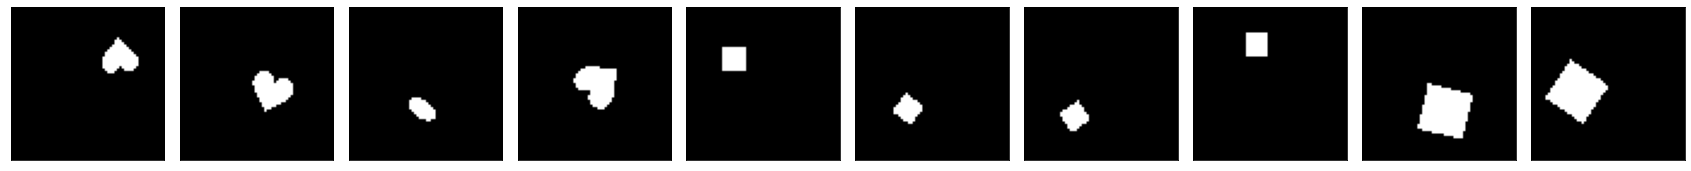

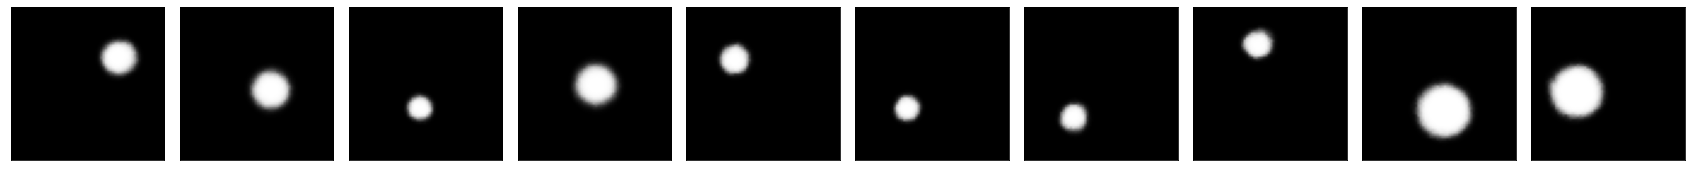

step 0/5760 in epoch 9
step 1000/5760 in epoch 9
step 2000/5760 in epoch 9
step 3000/5760 in epoch 9
step 4000/5760 in epoch 9
step 5000/5760 in epoch 9


EPOCH: 9; Train elbo (-loss): -149.216552734375;
Original then reconstruction.


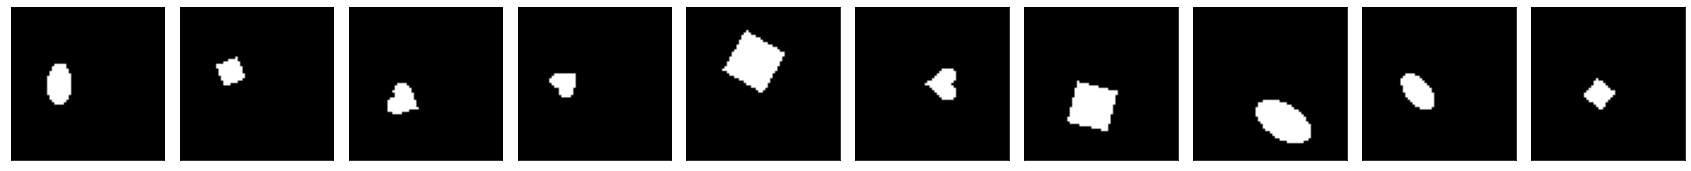

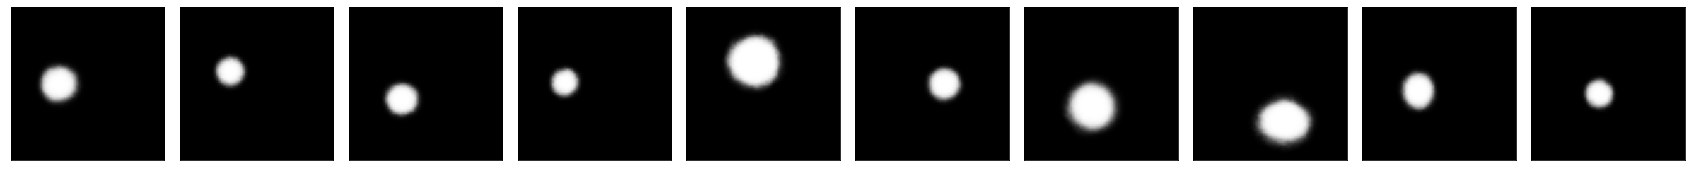

step 0/5760 in epoch 10
step 1000/5760 in epoch 10
step 2000/5760 in epoch 10
step 3000/5760 in epoch 10
step 4000/5760 in epoch 10
step 5000/5760 in epoch 10


EPOCH: 10; Train elbo (-loss): -147.63978576660156;
Original then reconstruction.


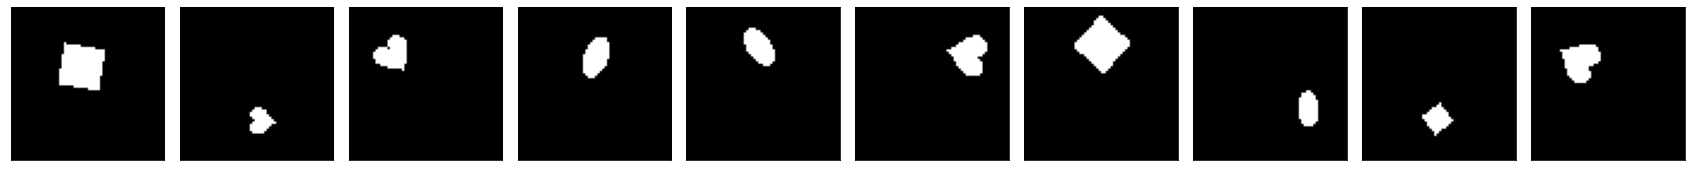

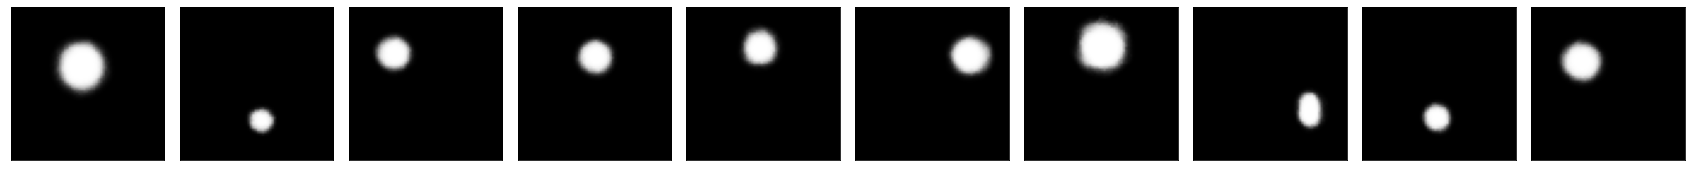

Done.


In [22]:
vae_dis, params_dis, training_stats_dis = disentangled_training(
    dsprites_vae_fn, final_kl_target=25, gamma=1000, num_epochs=10
)
print("Done.")

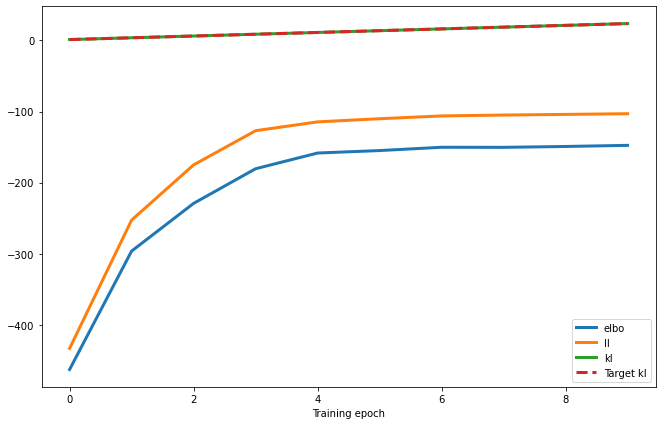

In [23]:
#@title Training Curves

plot_from = 0
plot_from = 1
f, ax = plt.subplots(1, 1, figsize=(11, 7))
for key in ['elbo', 'll', 'kl']:
  ax.plot(
      training_stats_dis[f'train_{key}'][plot_from:],
      label=f"{key}", lw=3)
ax.plot(
    training_stats_dis[f'kl_target'][plot_from:],
    label=f"Target kl", lw=3, linestyle='dashed')

ax.set_xlabel("Training epoch")
ax.legend()


In [ ]:
# pprint(training_stats_dis)

## Explore the Latent Space

In [24]:
rng_seq = hk.PRNGSequence(6235)
dsprites_ds = load_dsprites_ds(batch_size=64)


In [26]:

def get_latents(vae, params, dataset):
  zs, z_means, z_stddevs, labels = [], [], [], []
  for _ in range(5):
    batch = next(dataset)
    rec_output = vae.apply.reconstruct(
        params, next(rng_seq), batch["image"])
    zs.append(rec_output.z)
    z_means.append(rec_output.mean)
    z_stddevs.append(rec_output.stddev)
  del batch  # Keep memory usage low.

  zs = np.concatenate(zs, axis=0)
  z_means = np.concatenate(z_means, axis=0)
  z_stddevs = np.concatenate(z_stddevs, axis=0)
  return zs, z_means, z_stddevs


zs, z_means, z_stddevs = get_latents(
    vae_dis, params_dis, dsprites_ds)
latent_dim = z_means.shape[-1]

z_means.shape

(320, 10)

We start by exploring the latent distributions

1. componentwise,
2. pairwise,

using seaborn's pairplot.

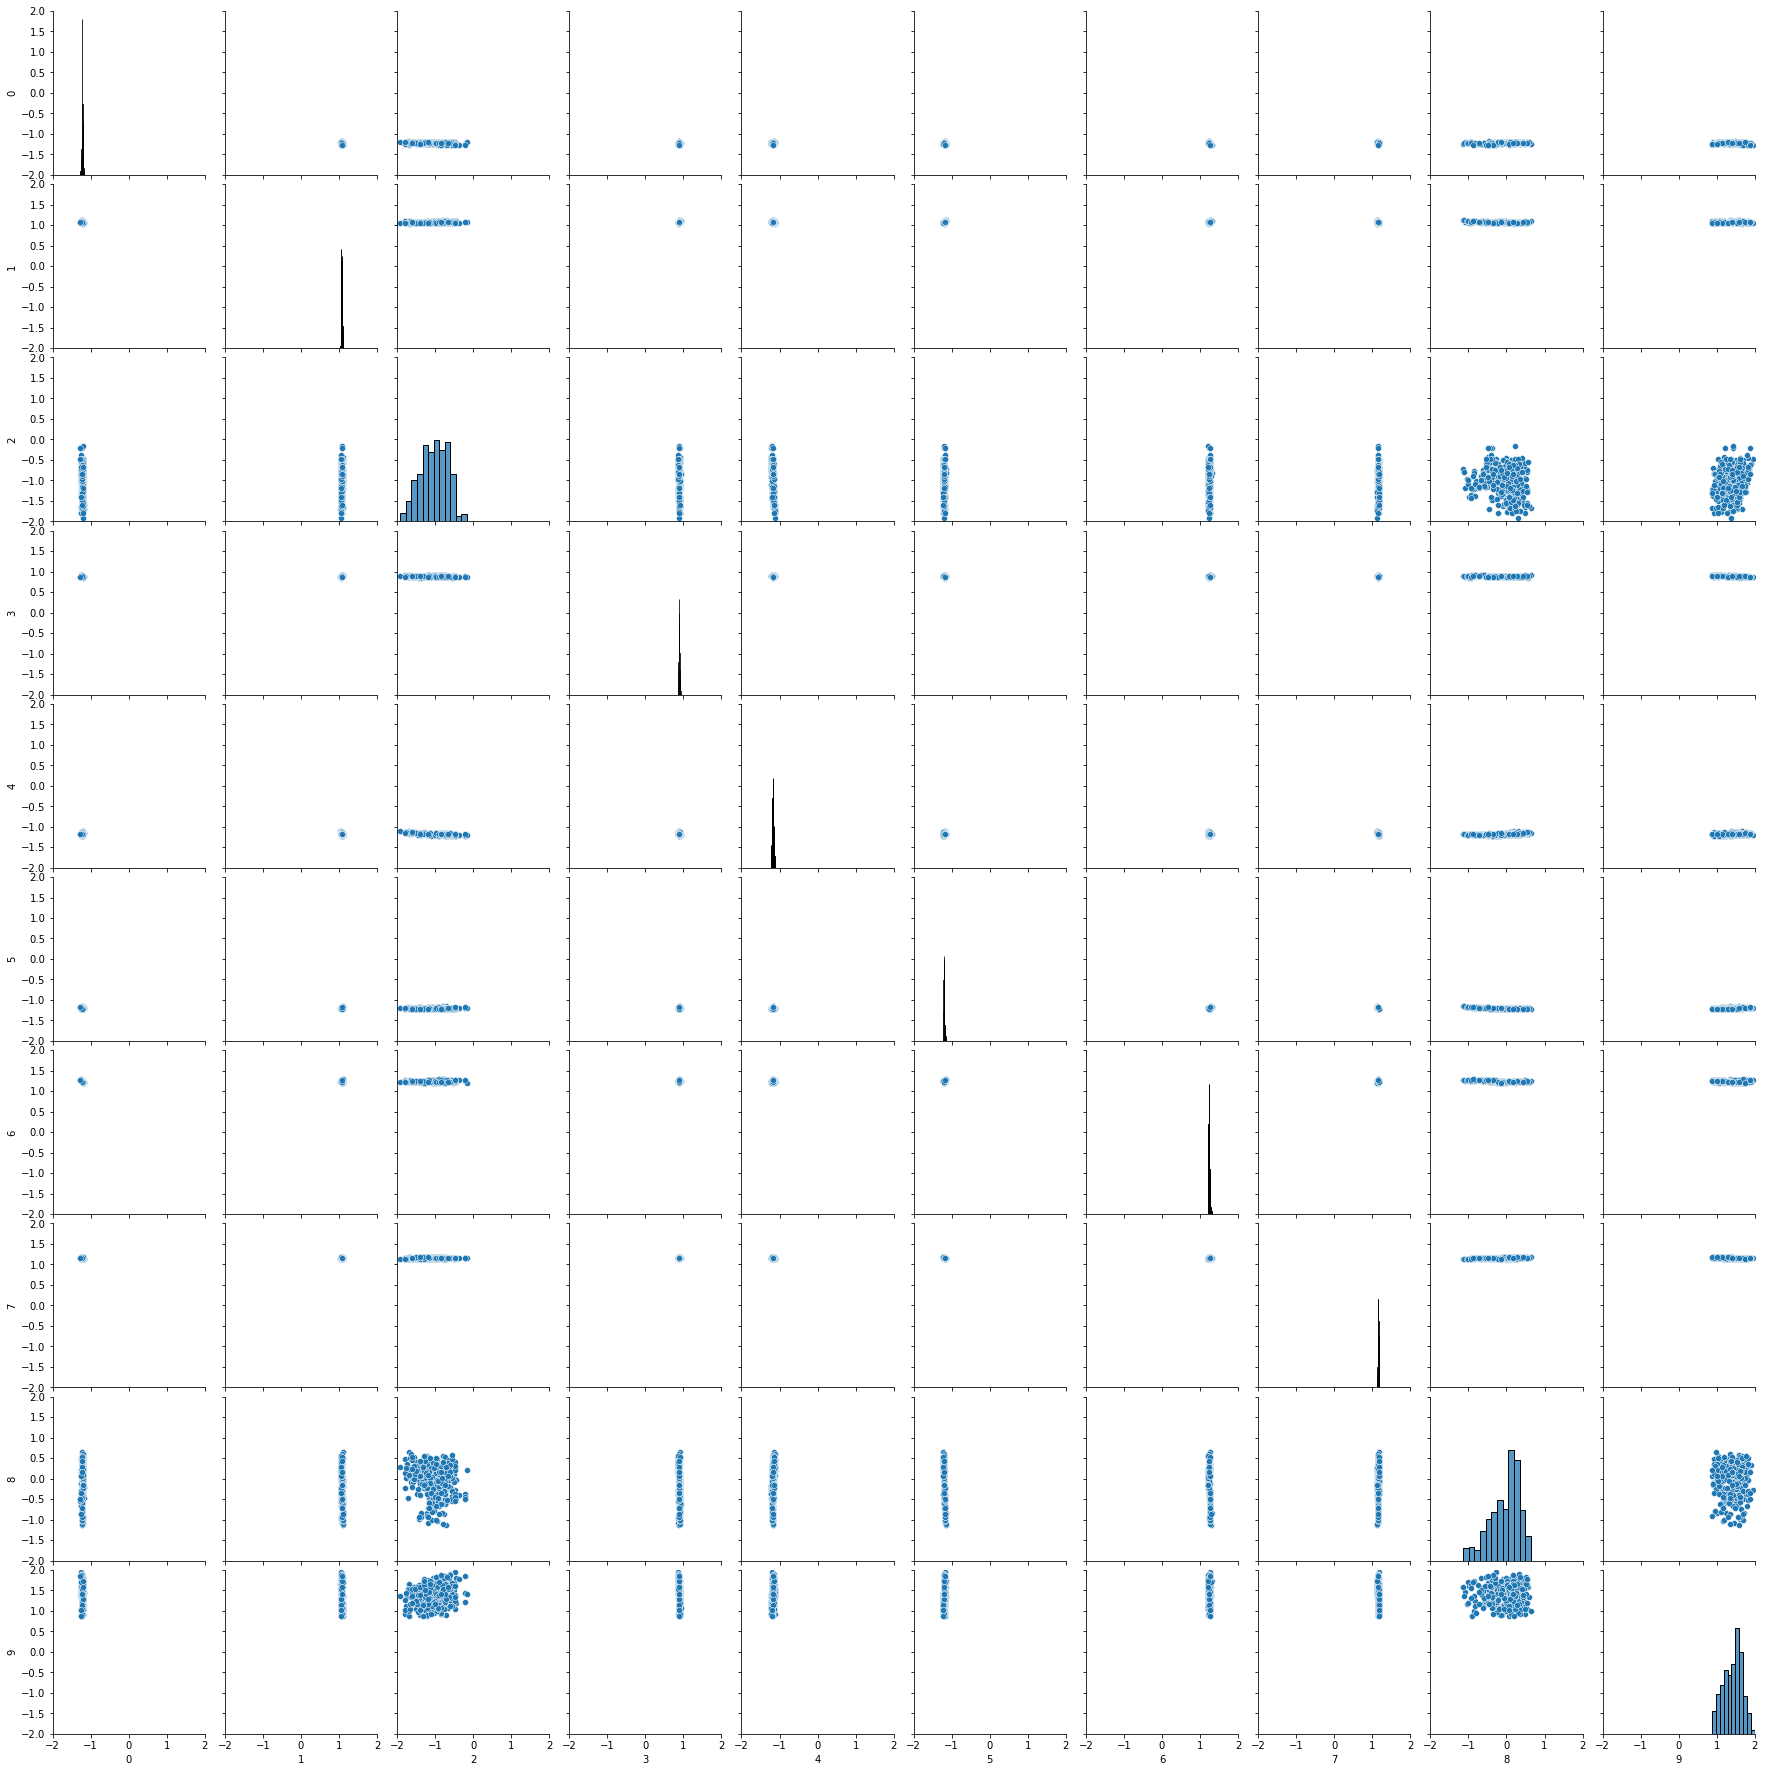

In [27]:
#@title Pairwise Latents
df_zs = pd.DataFrame(z_means)

pairplot = sns.pairplot(df_zs)
pairplot.set(xlim=(-2,2), ylim = (-2,2))

This allows us to find which latents are used (not collapsed) as well as their ranges.

We will use this information for "traversing" latents. To traverse latents:

1. Get the code for an image.
2. Pick some latents to vary across some range, while keeping the rest of the latents the same.


In [34]:
def explore_latents(
    vae, params, single_image_in_batch,
    dim_x, dim_y, num_explore=8, figsize=9):
  z, (mean, stddev) = vae.apply.encode(
      params, next(rng_seq), single_image_in_batch)
  base_z = mean[0]  # Single example.
  x_space = np.linspace(dim_x[1][0], dim_x[1][1], num_explore)
  y_space = np.linspace(dim_y[1][0], dim_y[1][1], num_explore)
  all_latents = []
  for y in y_space:
    for x in x_space:
      cur_z = np.array(base_z)
      cur_z[dim_x[0]] = x
      cur_z[dim_y[0]] = y
      all_latents.append(cur_z)
  all_latent_np = np.stack(all_latents)
  reconstructions, _ = vae.apply.decode(
      params, next(rng_seq), all_latent_np)
  print()
  # Plot them.
  for row_idx in range(num_explore):
    img_idx_start = row_idx * num_explore
    gallery(
        reconstructions[img_idx_start:],
        max_images=num_explore,
        max_fig_size=(figsize, figsize))

Pick an image from the following batch. Then read out which latents to use from the pairwise latent plot.

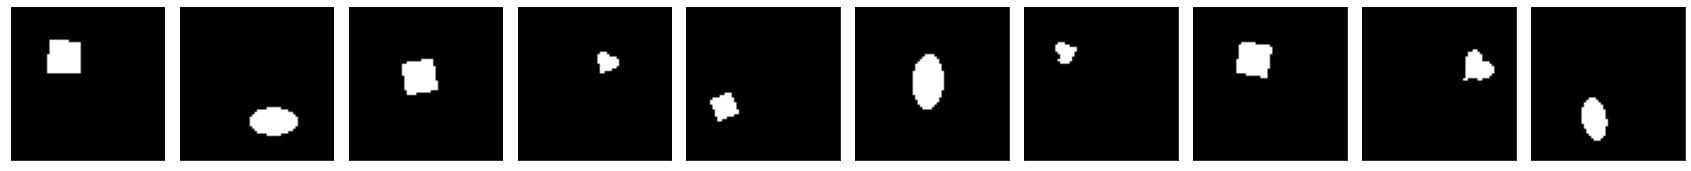

In [28]:
batch = next(dsprites_ds)
gallery(batch['image'])


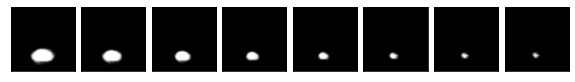

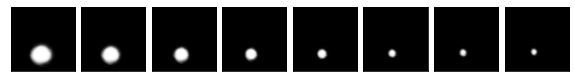

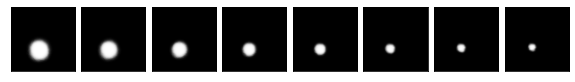

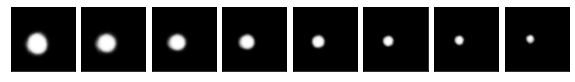

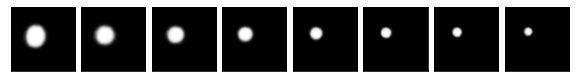

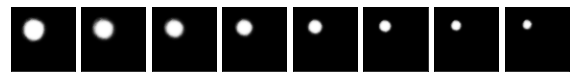

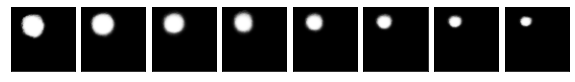

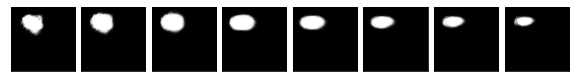

In [37]:
#@title Latent Traversal
dim_y = 2, [-2, 0] # axis, range
dim_x = 9, [1, 2] # axis, range
example_in_batch = 0

explore_latents(
    vae_dis, params_dis,
    batch['image'][np.newaxis, example_in_batch],
    dim_x, dim_y, num_explore=8, figsize=10)

**Latent Interpretations.** We see that the selected latents correspond to generating factors of the dataset! Do you think this will always be the case? What may determine if this is the case?

**Generalization.** We trained on the whole dataset. We could split the data into a train and test set to see if we can learn a representation that generalizes to unseen data. For example, when generating images across the x-position latent:

1. skip x positions around the center of the image. (interpolation)
2. skip x positions on the right hand side. (extrapolation)

Do you think the representations learnt would generalize?

**Exercise**: our model was not able to

1. fully reconstruct images, e.g. the shapes are lost.
2. learn latents for all generating factors.

Can you make it work? What steps would you take?

**Resources**

* [beta-VAE: Learning Basic Visual Concepts with a Constrained Variational Framework](https://openreview.net/forum?id=Sy2fzU9gl): original introduction of beta-VAE, for disentangling.
* [Understanding disentangling in β-VAE](https://arxiv.org/abs/1804.03599): a development of understanding of what actually happens in a beta-VAE. Also introduced the training regime used in this colab.
* [Towards a Definition of Disentangled Representations](https://arxiv.org/abs/1812.02230): What is a disentangled representation even?